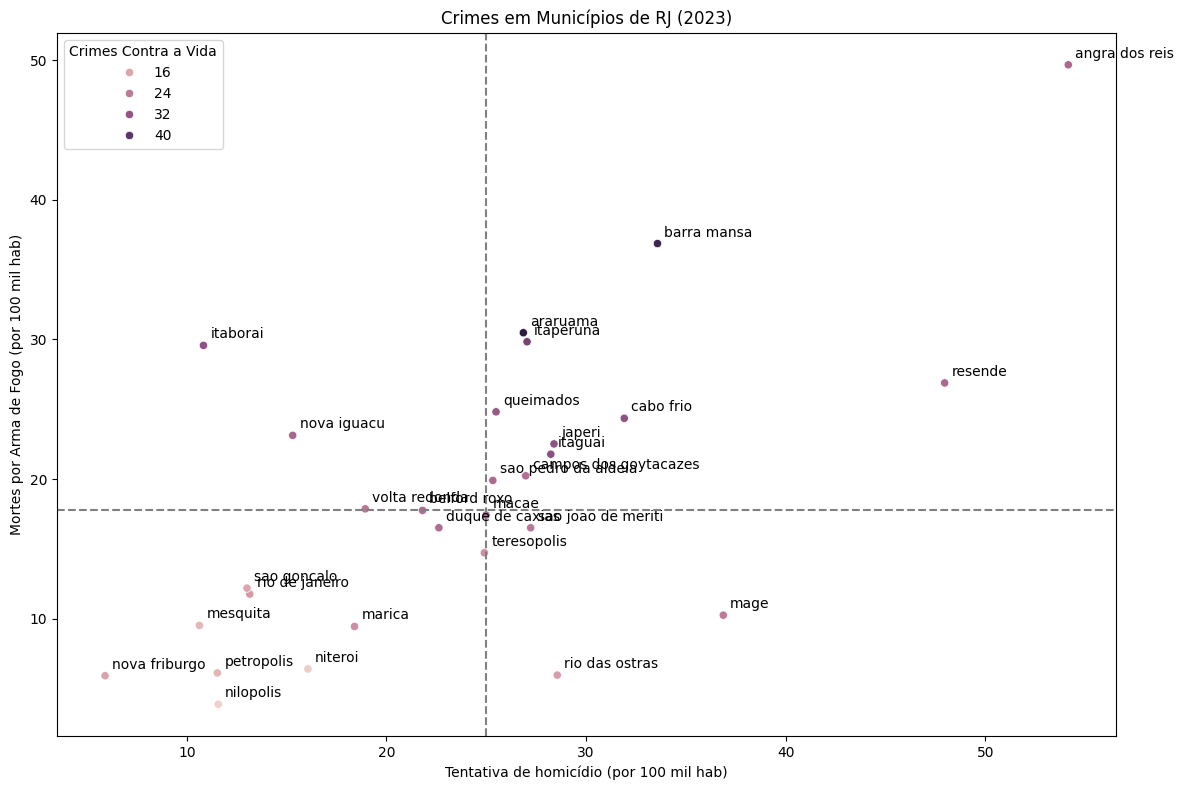

                         Tentativa de homicídio  Morte no trânsito  \
Tentativa de homicídio                 1.000000           0.203622   
Morte no trânsito                      0.203622           1.000000   
Crimes Contra a Vida                   0.486880           0.342770   
Mortes por Arma de Fogo                0.657158           0.360691   

                         Crimes Contra a Vida  Mortes por Arma de Fogo  
Tentativa de homicídio               0.486880                 0.657158  
Morte no trânsito                    0.342770                 0.360691  
Crimes Contra a Vida                 1.000000                 0.786134  
Mortes por Arma de Fogo              0.786134                 1.000000  
                       Tentativa de homicídio  Morte no trânsito  \
municipio                                                          
angra dos reis                      54.153640          20.098258   
araruama                            26.855770          19.597454   
barra mansa 

In [1]:
import pandas as pd
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt

def remover_acentos(texto):
    """Remove acentos de uma string."""
    normalizado = unicodedata.normalize('NFKD', str(texto))
    sem_acentos = ''.join([c for c in normalizado if not unicodedata.combining(c)])
    return sem_acentos

def formatar_municipio(municipio):
    """Formata o nome do município."""
    if municipio == 'NÃO INFORMADO':
        return 'NÃO INFORMADO'
    elif pd.isna(municipio):
        return 'NÃO INFORMADO'
    else:
        return str(municipio).lower()

def analisar_criminalidade_por_uf(uf, ano=2023, populacao_minima=100000):
    """
    Função para análise detalhada de criminalidade por UF
    
    Parâmetros:
    - uf: Sigla do estado a ser analisado
    - ano: Ano da análise (padrão 2023)
    - populacao_minima: População mínima para inclusão dos municípios
    
    Retorna dicionário com DataFrames e visualizações
    """
    # Carregar dados
    df_obitos_arma_fogo = pd.read_csv(r'C:\Users\daviw\OneDrive\Projetos\Python\Segurança Pública\data\processed\obitos_datasus.csv')
    df_populacao = pd.read_excel(r'C:\Users\daviw\OneDrive\Projetos\Python\Segurança Pública\data\raw\estimativa_dou_2024.xls', 
                                  sheet_name='MUNICÍPIOS', skiprows=1, skipfooter=1)
    df = pd.read_parquet(r'C:\Users\daviw\OneDrive\Projetos\Python\Segurança Pública\data\processed\df_unificado.parquet')
    
    # Preparar dados
    df_populacao['NOME DO MUNICÍPIO'] = df_populacao['NOME DO MUNICÍPIO'].astype(str).apply(remover_acentos)
    df_populacao['chave'] = df_populacao['UF'] + df_populacao['NOME DO MUNICÍPIO'].str.lower()
    
    df['municipio'] = df['municipio'].apply(formatar_municipio)
    df['municipio'] = df['municipio'].apply(remover_acentos)
    df['chave_uf'] = df['uf'] + df['municipio']
    
    # Filtrar por UF e ano
    df_uf = df[df['uf'] == uf].reset_index(drop=True)
    df_uf_c_mun = df_uf[df_uf['municipio'] != 'NAO INFORMADO'].reset_index(drop=True)
    df_uf_c_mun = df_uf_c_mun[df_uf_c_mun['ano'] == ano]
    
    # Adicionar população e óbitos
    df_uf_c_mun['populacao'] = df_uf_c_mun['chave_uf'].map(df_populacao.set_index('chave')['POPULAÇÃO ESTIMADA'])
    df_uf_c_mun['obitos'] = df_uf_c_mun['chave_uf'].map(df_obitos_arma_fogo.set_index('chave_uf')['obitos'])
    
    # Criar chave de agrupamento
    df_uf_c_mun['chave_agrupamento'] = (df_uf_c_mun['uf'] + "," + 
                                         df_uf_c_mun['municipio'] + "," + 
                                         df_uf_c_mun['evento'] + "," + 
                                         df_uf_c_mun['ano'].astype(str) + "," + 
                                         df_uf_c_mun['categoria'])
    
    # Agregar dados
    agrupamento_valor = df_uf_c_mun.groupby('chave_agrupamento')['valor'].sum().reset_index()
    agrupamento_obitos = df_uf_c_mun.groupby('chave_agrupamento')['obitos'].min().reset_index()
    agrupamento_populacao = df_uf_c_mun.groupby('chave_agrupamento')['populacao'].min().reset_index()
    
    # Mesclar dados
    df_agrupado = agrupamento_valor.merge(agrupamento_obitos, on="chave_agrupamento")
    df_agrupado = df_agrupado.merge(agrupamento_populacao, on="chave_agrupamento")
    
    # Calcular taxas
    df_agrupado['tx_100_mil_hab'] = df_agrupado['valor'] / df_agrupado['populacao'] * 100000
    df_agrupado['obitos_100_mil_hab'] = df_agrupado['obitos'] / df_agrupado['populacao'] * 100000
    
    # Expandir dados
    df_expandido = df_agrupado.copy()
    df_expandido[['estado', 'municipio', 'crime', 'ano', 'categoria']] = df_expandido['chave_agrupamento'].str.split(',', expand=True)
    df_expandido = df_expandido.drop(columns=['chave_agrupamento'])
    df_expandido = df_expandido[['estado', 'municipio', 'crime', 'ano', 'categoria', 'valor', 'obitos', 'populacao', 'tx_100_mil_hab', 'obitos_100_mil_hab']]
    
    # Filtrar por população mínima
    df_uf_mun_100k = df_expandido[(df_expandido['populacao'] > populacao_minima)].reset_index(drop=True)
    
    # Variáveis selecionadas
    vars_selecionadas = {}
    tent_hom = df_uf_mun_100k[df_uf_mun_100k['categoria'] == 'Tentativa de homicídio'].groupby('municipio')['tx_100_mil_hab'].sum().sort_values(ascending=True)
    morte_transito = df_uf_mun_100k[df_uf_mun_100k['categoria'] == 'Morte no trânsito ou em decorrência dele (exceto homicídio doloso)'].groupby('municipio')['tx_100_mil_hab'].sum().sort_values(ascending=True)
    crimes_vida = df_uf_mun_100k[df_uf_mun_100k['categoria'] == 'Crimes Contra a Vida'].groupby('municipio')['tx_100_mil_hab'].sum().sort_values(ascending=True)
    mortes_arma_fogo = df_uf_mun_100k.groupby('municipio')['obitos_100_mil_hab'].mean().sort_values(ascending=True)
    
    vars_selecionadas['Tentativa de homicídio'] = tent_hom
    vars_selecionadas['Morte no trânsito'] = morte_transito
    vars_selecionadas['Crimes Contra a Vida'] = crimes_vida
    vars_selecionadas['Mortes por Arma de Fogo'] = mortes_arma_fogo
    
    df_variaveis_selecionadas = pd.DataFrame(vars_selecionadas)
    
    # Visualizações
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        data=df_variaveis_selecionadas,
        x='Tentativa de homicídio',
        y='Mortes por Arma de Fogo',
        hue='Crimes Contra a Vida'
    )
    
    media_x = df_variaveis_selecionadas['Tentativa de homicídio'].quantile(0.5)
    media_y = df_variaveis_selecionadas['Mortes por Arma de Fogo'].quantile(0.5)
    
    ax.axvline(media_x, color='gray', linestyle='--')
    ax.axhline(media_y, color='gray', linestyle='--')
    
    for idx, row in df_variaveis_selecionadas.iterrows():
        ax.annotate(
            idx,
            (row['Tentativa de homicídio'], row['Mortes por Arma de Fogo']),
            textcoords="offset points",
            xytext=(5, 5),
            ha='left'
        )
    
    plt.title(f'Crimes em Municípios de {uf} ({ano})')
    plt.xlabel('Tentativa de homicídio (por 100 mil hab)')
    plt.ylabel('Mortes por Arma de Fogo (por 100 mil hab)')
    plt.legend(title='Crimes Contra a Vida')
    plt.tight_layout()
    plt.show()
    
    # Retornar resultados
    return {
        'dados_municipios': df_uf_mun_100k,
        'variaveis_selecionadas': df_variaveis_selecionadas,
        'correlacao': df_variaveis_selecionadas.corr()
    }

# Exemplo de uso
resultado_RJ = analisar_criminalidade_por_uf('RJ')
print(resultado_RJ['correlacao'])
print(resultado_RJ['variaveis_selecionadas'])